Used Machine Learning algorithms for performing classification of audio files to different genre classes. The dataset used here is the features extracted by processing the 30 seconds audio files from GTZAN dataset http://marsyas.info/downloads/datasets.html. 

We have 10 genre classes : blues,hiphop,classical,country,disco,jazz,metal,pop,reggae,rock.

In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [2]:
file_path='../input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv'

In [3]:
data=pd.read_csv(file_path)
data=data.iloc[0:, 1:] 
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   length                   1000 non-null   int64  
 1   chroma_stft_mean         1000 non-null   float64
 2   chroma_stft_var          1000 non-null   float64
 3   rms_mean                 1000 non-null   float64
 4   rms_var                  1000 non-null   float64
 5   spectral_centroid_mean   1000 non-null   float64
 6   spectral_centroid_var    1000 non-null   float64
 7   spectral_bandwidth_mean  1000 non-null   float64
 8   spectral_bandwidth_var   1000 non-null   float64
 9   rolloff_mean             1000 non-null   float64
 10  rolloff_var              1000 non-null   float64
 11  zero_crossing_rate_mean  1000 non-null   float64
 12  zero_crossing_rate_var   1000 non-null   float64
 13  harmony_mean             1000 non-null   float64
 14  harmony_var              

In [4]:
print(data.head(10))

   length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  661794          0.350088         0.088757  0.130228  0.002827   
1  661794          0.340914         0.094980  0.095948  0.002373   
2  661794          0.363637         0.085275  0.175570  0.002746   
3  661794          0.404785         0.093999  0.141093  0.006346   
4  661794          0.308526         0.087841  0.091529  0.002303   
5  661794          0.302456         0.087532  0.103494  0.003981   
6  661794          0.291328         0.093981  0.141874  0.008803   
7  661794          0.307955         0.092903  0.131822  0.005531   
8  661794          0.408879         0.086512  0.142416  0.001507   
9  661794          0.273950         0.092316  0.081314  0.004347   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.165850           1.297741e+05              2002.449060   
1             1530.176679           3.758501e+05              2039.036516   
2             1552.8

In [5]:
y = data['label']       # genre variable.
X = data.loc[:, data.columns != 'label']     #select all columns but not the labels

In [6]:
X.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


First we will perform normalization to keep the values of all the features in the dataset on the same scale.

In [7]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

Splitting data into training and testing dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

We will define functions to train and assess the accuracy of a model 

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc=round(accuracy_score(y_test, preds), 5)
    print('Accuracy', title, ':', acc, '\n')
    
     # Let's see the confusion matrix of the last split for a little insight
    con_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize = (10, 6))
    sns.heatmap(con_mat, cmap="Blues", annot=True, 
                xticklabels = ["blues", "classical", "country", "disco", 
                               "hiphop", "jazz", "metal", "pop", "reggae", "rock"], 
                yticklabels=["blues", "classical", "country", "disco", "hiphop", 
                             "jazz", "metal", "pop", "reggae", "rock"])
    plt.show()

    return acc

Base classifier models

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy Logistic Regression : 0.67 



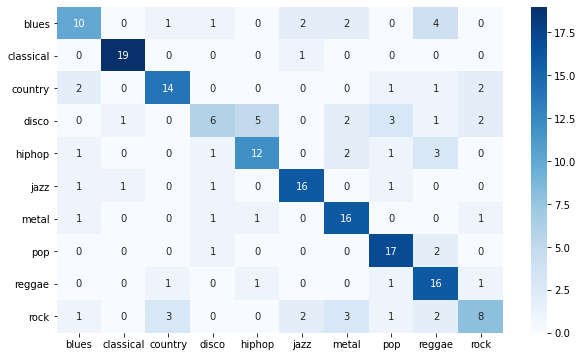

In [16]:
# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
lg_acc=model_assess(lg, "Logistic Regression")



Accuracy Support Vector Machine : 0.705 



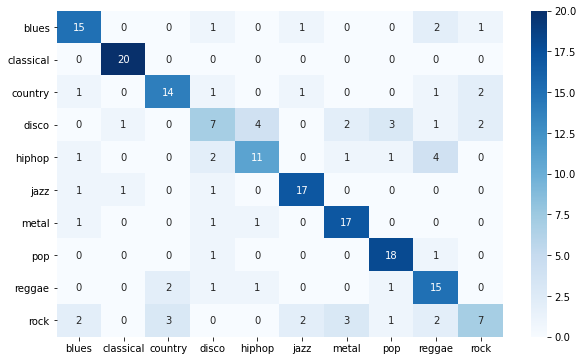

In [17]:
# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
svm_acc=model_assess(svm, "Support Vector Machine")



Accuracy Decission trees : 0.615 



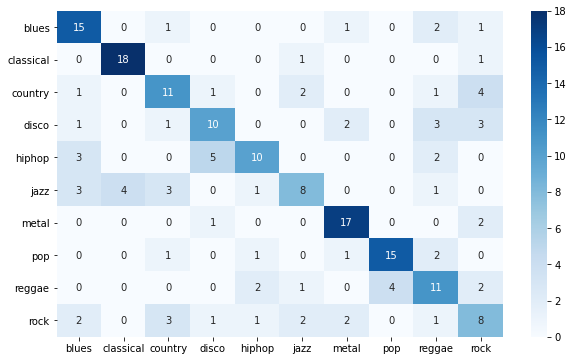

In [18]:
# Decission trees
dtree = DecisionTreeClassifier()
dtree_acc=model_assess(dtree, "Decission trees")



Accuracy Random Forest : 0.805 



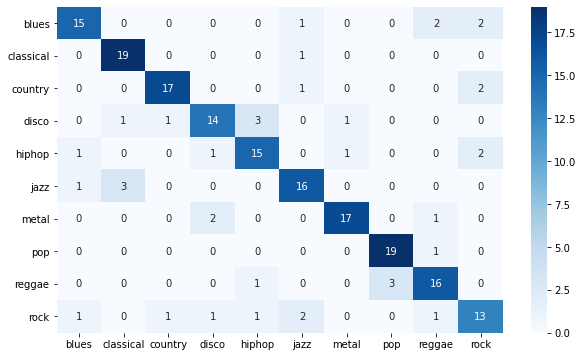

In [19]:
# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
rforest_acc=model_assess(rforest, "Random Forest")




Accuracy Cross Gradient Booster : 0.745 



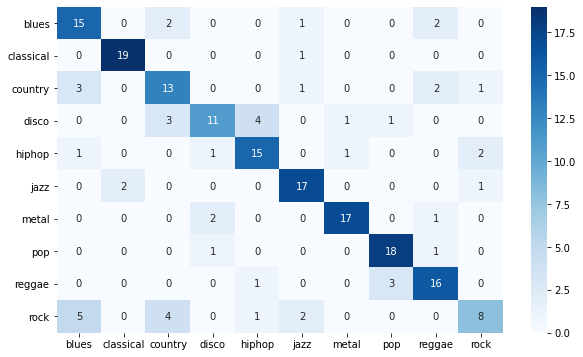

In [20]:
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb_acc=model_assess(xgb, "Cross Gradient Booster")

we have used RandomizedSearchCV function to implement finetuning of the parameters for these machine learning models.This helps to obtain the optimum values of the hyperparameters and reduce the case of overfitting

### Decision Tree Classifier

In [21]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [2,3,4,6],
              "max_features": [8,10,11,12,14],
              "min_samples_leaf": [2,4,6,8,10],
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))

Tuned Decision Tree Parameters: {'min_samples_leaf': 2, 'max_features': 12, 'max_depth': 6, 'criterion': 'entropy'}


In [22]:
opt_decisiontree=DecisionTreeClassifier(criterion='entropy',max_depth=6,max_features=8,min_samples_leaf=4)

Accuracy Decission trees : 0.53 



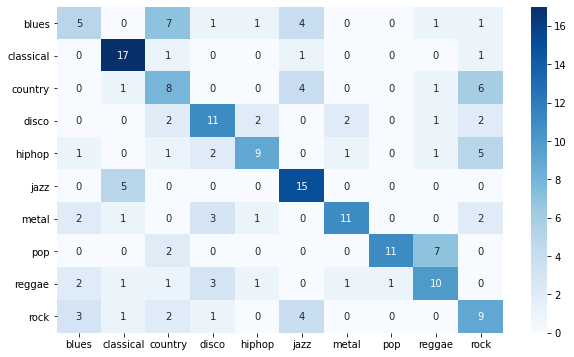

In [23]:
opt_dtree_acc=model_assess(opt_decisiontree, "Decission trees")

### Random Forest Classifier

In [24]:
from scipy.stats import truncnorm, uniform

model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199),
    "criterion": ["gini", "entropy"]
}

# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=100, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 0.34082380566905934,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.012776363022143807,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 92,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Accuracy Random Forest : 0.715 



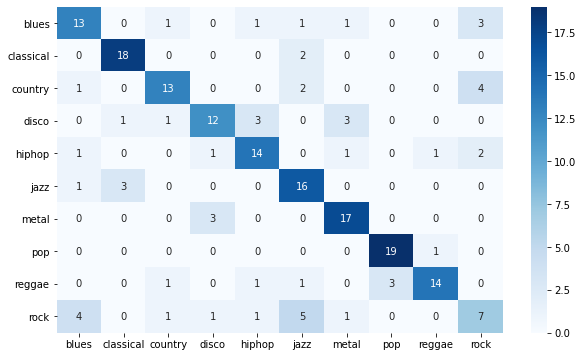

In [25]:
rforest_best = RandomForestClassifier(n_estimators=190,max_depth=4,criterion='gini',max_features=0.26750178061074575,
                                     min_samples_leaf=2,random_state=0,verbose=0,ccp_alpha=0.0,warm_start=False)
opt_rforest_acc=model_assess(rforest_best, "Random Forest") 

### Support Vector Classifier

In [26]:
default_SVC = SVC()
print ("Default SVC parameters are: \n{}".format(default_SVC.get_params))
# Designate distributions to sample hyperparameters from 
np.random.seed(123)
g_range = np.random.uniform(0.0, 0.3, 5).astype(float)
C_range = np.random.normal(1, 0.1, 5).astype(float)
 
# Check that gamma>0 and C>0 
C_range[C_range < 0] = 0.0001
 
hyperparameters = {'gamma': list(g_range), 
                    'C': list(C_range)}
 
print (hyperparameters)

Default SVC parameters are: 
<bound method BaseEstimator.get_params of SVC()>
{'gamma': [0.2089407556793585, 0.08584180048511383, 0.06805543606926093, 0.16539443072486737, 0.2158406909356689], 'C': [1.0322106068339623, 0.9948482279060615, 0.9795799035361106, 1.197934843277785, 0.8380699934963254]}


In [27]:
# Run randomized search
randomCV = RandomizedSearchCV(SVC(kernel='rbf', ), param_distributions=hyperparameters, n_iter=20)
randomCV.fit(X_train,y_train)
 
# Identify optimal hyperparameter values
best_gamma  = randomCV.best_params_['gamma']
best_C      = randomCV.best_params_['C']
 
print("The best performing gamma value is: {:5.2f}".format(best_gamma))
print("The best performing C value is: {:5.2f}".format(best_C))

The best performing gamma value is:  0.22
The best performing C value is:  0.99


Accuracy Support Vector Machine : 0.675 



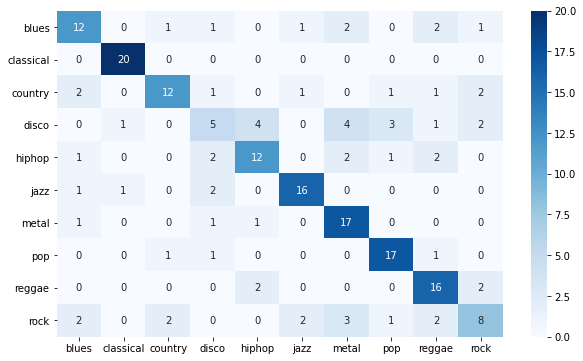

In [28]:
from sklearn import metrics

# Train SVM and output predictions
rbfSVM = SVC(kernel='rbf', C=best_C,decision_function_shape="ovo", gamma=best_gamma)
opt_svc_acc=model_assess(rbfSVM, "Support Vector Machine")

### Logistic Regression Classifier

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


best params 'penalty':  l2
best params 'C':  3.730229437354635
Accuracy Logistic Regression : 0.695 



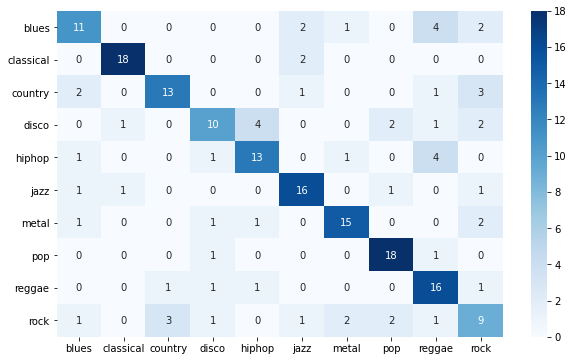

In [29]:
from scipy.stats import uniform

# Create logistic regression
logistic = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create randomized search 5-fold cross validation and 100 iterations
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
clf.fit(X_train,y_train)

print("best params 'penalty': ",clf.best_params_['penalty'])
print("best params 'C': ",clf.best_params_['C'])
best_logisticmodel=LogisticRegression(penalty='l2',C=3.73022, random_state=10,solver='lbfgs', multi_class='multinomial')
opt_lg_acc=model_assess(best_logisticmodel, "Logistic Regression")

### XGBoost classifier

In [30]:
import xgboost as xgb
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "exact",
                            objective = "multi:softmax")
# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, random_state = 40 )


In [31]:
# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)
print(model_xgboost.best_params_)

{'subsample': 0.4, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}


Accuracy Cross Gradient Booster : 0.795 



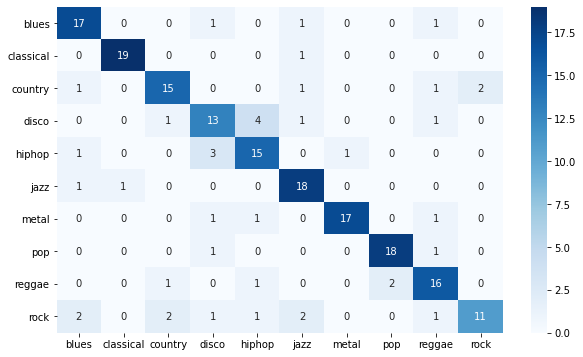

In [32]:
optimum_xgbclf= xgb.XGBClassifier(tree_method = "exact",learning_rate=0.01,gamma=0.3,max_depth=7,
                            objective = "multi:softmax",colsample_bytree= 0.3,subsample=0.4,
                                  reg_alpha=0,reg_lambda=1.5,min_child_weight= 1,n_estimators= 1000)

opt_xgb_acc=model_assess(optimum_xgbclf, "Cross Gradient Booster")

Deep Learning Model:
we will build simple neural network model as classifier using keras. 